In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


**The tools I have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  My goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below)**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The first set of outputs should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> After some modifications, the lanes are connected via connecting/averaging/extrapolating line segments to get output like this</p> 
 </figcaption>
</figure>

**We first run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


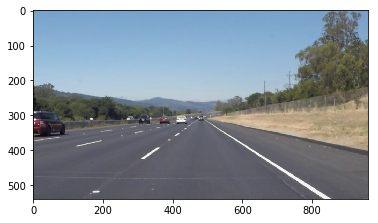

In [2]:
#reading in an image
image = mpimg.imread("test_images/solidWhiteRight.jpg")

#printing out some stats and plotting
print("This image is:", type(image), "with dimensions:", image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

### Here is that gist of the approach I am taking to capture the lanes: 

* in `draw_lines` function: 
  * I define two filtering tolerance variables, `horizontalSlopeTol` and `verticalSlopeTol`, to filter out close-tohorizontal and close-to-vertical lines. This helps remove some noisy lines. 
  * I distinguish between positive and negative slope lines. So the representative lines have slope by introducing two variables `avgPositiveSlope` and `avgNegativeSlope`. Accordingly, the captured lines are stored in `positiveSlopeLines` and `negativeSlopeLines` variables. 
  * The averaged / extended lines are defined using the slopes mentioned above. The averaged lines are `extendedPositiveSlopeLine` and `extendedNegativeSlopeLine`. 

* I got better results using the color -  original - images instead of using gray ones 


Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    if(lines is None):
        return
    
    horizontalSlopeTol = 0.5
    verticalSlopeTol = 2.0
    slopes = np.zeros(len(lines))
    lengths = np.zeros(len(lines))
    validLinesindices = []
    halfWidth = img.shape[1] / 2
    
    extendedPositiveSlopeLine = [[0, 0, 0, 0]]
    extendedNegativeSlopeLine = [[0, 0, 0, 0]]
    
    for index, line in enumerate(lines):
        
        for x1, y1, x2, y2 in line:
            
            deltaY = y2 - y1
            deltaX = x2 - x1
            lengths[index] = math.sqrt(deltaX*deltaX + deltaY*deltaY)
            
            # Calculating a Weighted slope, based on the length of the line for a smoother experience
            # slopes[index] = lengths[index] * (deltaY / deltaX)
            slopes[index] = deltaY / deltaX
            
            if(abs(slopes[index]) < horizontalSlopeTol or abs(slopes[index]) > verticalSlopeTol
              or (slopes[index] >= 0.0 and x1 < halfWidth) or (slopes[index] < 0.0 and x1 > halfWidth)):
                continue
            
            validLinesindices.append(index)

            # cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    lines = lines[validLinesindices]
    lengths = lengths[validLinesindices]
    slopes = slopes[validLinesindices]
    
    positiveSlopesIndices = np.where(slopes >= 0.0)
    negativeSlopesIndices = np.where(slopes < 0.0)
    
    # For average lines
    avgPositiveSlope = np.sum(slopes[positiveSlopesIndices] * lengths[positiveSlopesIndices]) / np.sum(lengths[positiveSlopesIndices])
    avgNegativeSlope = np.sum(slopes[negativeSlopesIndices] * lengths[negativeSlopesIndices]) / np.sum(lengths[negativeSlopesIndices])
    
    positiveSlopeLines = lines[positiveSlopesIndices]
    negativeSlopeLines = lines[negativeSlopesIndices]
    
    if(len(positiveSlopeLines) > 0):
        argmin = np.argmin([line[0][0] for line in positiveSlopeLines])
        
        x1 = positiveSlopeLines[argmin][0][0]
        y1 = positiveSlopeLines[argmin][0][1]
        
        # x1 = min([line[0][0] for line in positiveSlopeLines])
        # y1 = min([line[0][1] for line in positiveSlopeLines])
        y2 = img.shape[0]
        x2 = int((y2 - y1) / avgPositiveSlope + x1)
        # x2 = max([line[0][2] for line in positiveSlopeLines])
        # y2 = max([line[0][3] for line in positiveSlopeLines])
        extendedPositiveSlopeLine = [[x1, y1, x2, y2]]
    else:
        extendedPositiveSlopeLine = []

    if(len(negativeSlopeLines) > 0):
        argmin = np.argmin([line[0][1] for line in negativeSlopeLines])
        
        x1 = negativeSlopeLines[argmin][0][0]
        y1 = negativeSlopeLines[argmin][0][1]

        #x1 = max([line[0][0] for line in negativeSlopeLines])
        #y1 = min([line[0][1] for line in negativeSlopeLines])
        x2 = int((y2 - y1) / avgNegativeSlope + x1)
        y2 = img.shape[0]

        # y1 = img.shape[0]
        # x2 = max([line[0][2] for line in negativeSlopeLines])
        # y2 = min([line[0][3] for line in negativeSlopeLines])
        # x1 = int(x2 - (y2 - y1) / avgNegativeSlope)
        extendedNegativeSlopeLine = [[x1, y1, x2, y2]]
    else:
        extendedNegativeSlopeLine = []

    for x1, y1, x2, y2 in extendedPositiveSlopeLine:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        text = "Positive: slope:{0:1.3f}, x1:{1:d}, y1:{2:d}, x2:{3:d}, y2:{4:d}".format(avgPositiveSlope, x1, y1, x2, y2)
        # text = "Positive slope: slope:{0:}".format(extendedPositiveSlopeLine)
        cv2.putText(img, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255, 255, 0))
    
    for x1, y1, x2, y2 in extendedNegativeSlopeLine:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        text = "Negative: slope:{0:1.3f}, x1:{1:d}, y1:{2:d}, x2:{3:d}, y2:{4:d}".format(avgNegativeSlope, x1, y1, x2, y2)
        cv2.putText(img, text, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255, 255, 0))

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, color=[255, 0, 0], thickness=8)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1.0, γ=0.0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['Results',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

- Color Selection
- Region Masking
- Canny Edges
- Hough Transform


In [5]:
def extractLanes(image):
    # gray = grayscale(image)
    gray = image

    # Defining a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Defining our parameters for Canny and apply
    # low_threshold = 40
    # high_threshold = 200

    # to capture the bottom of the image to define the thresholds, focusing on the road portion
    bottomImage = image[image.shape[0]//2:, :]
    
    low_threshold = np.mean(bottomImage * 255)
    high_threshold = 1.33 * low_threshold

    edges = canny(blur_gray, low_threshold, high_threshold)

    # Creating a masked edges image
    # mask = np.zeros_like(edges)   

    # defining a trapezoid region to mimic perspective impression of the meeting lanes
    x1 = image.shape[1] * 0.08
    y1 = image.shape[0]

    x2 = image.shape[1] * 0.4
    y2 = image.shape[0] * 0.62

    x3 = image.shape[1] * 0.6
    y3 = image.shape[0] * 0.62

    x4 = image.shape[1] * 0.92
    y4 = image.shape[0]

    vertices = np.array([[(x1, y1), (x2, y2), (x3, y3), (x4, y4)]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)

    # Defining the Hough transform parameters and making a blank the same size as our image to draw on
    # distance resolution in pixels of the Hough grid
    rho = 1

    # angular resolution in radians of the Hough grid
    theta = 1.0 * np.pi/180

    # minimum number of votes (intersections in Hough grid cell)
    threshold = 10

    #minimum number of pixels making up a line
    min_line_length = 10

    # maximum gap in pixels between connectable line segments
    max_line_gap = 50

    lineImage = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    weightedImage = weighted_img(lineImage, image, α=0.7, β=1.0, γ=0.0)

    return weightedImage

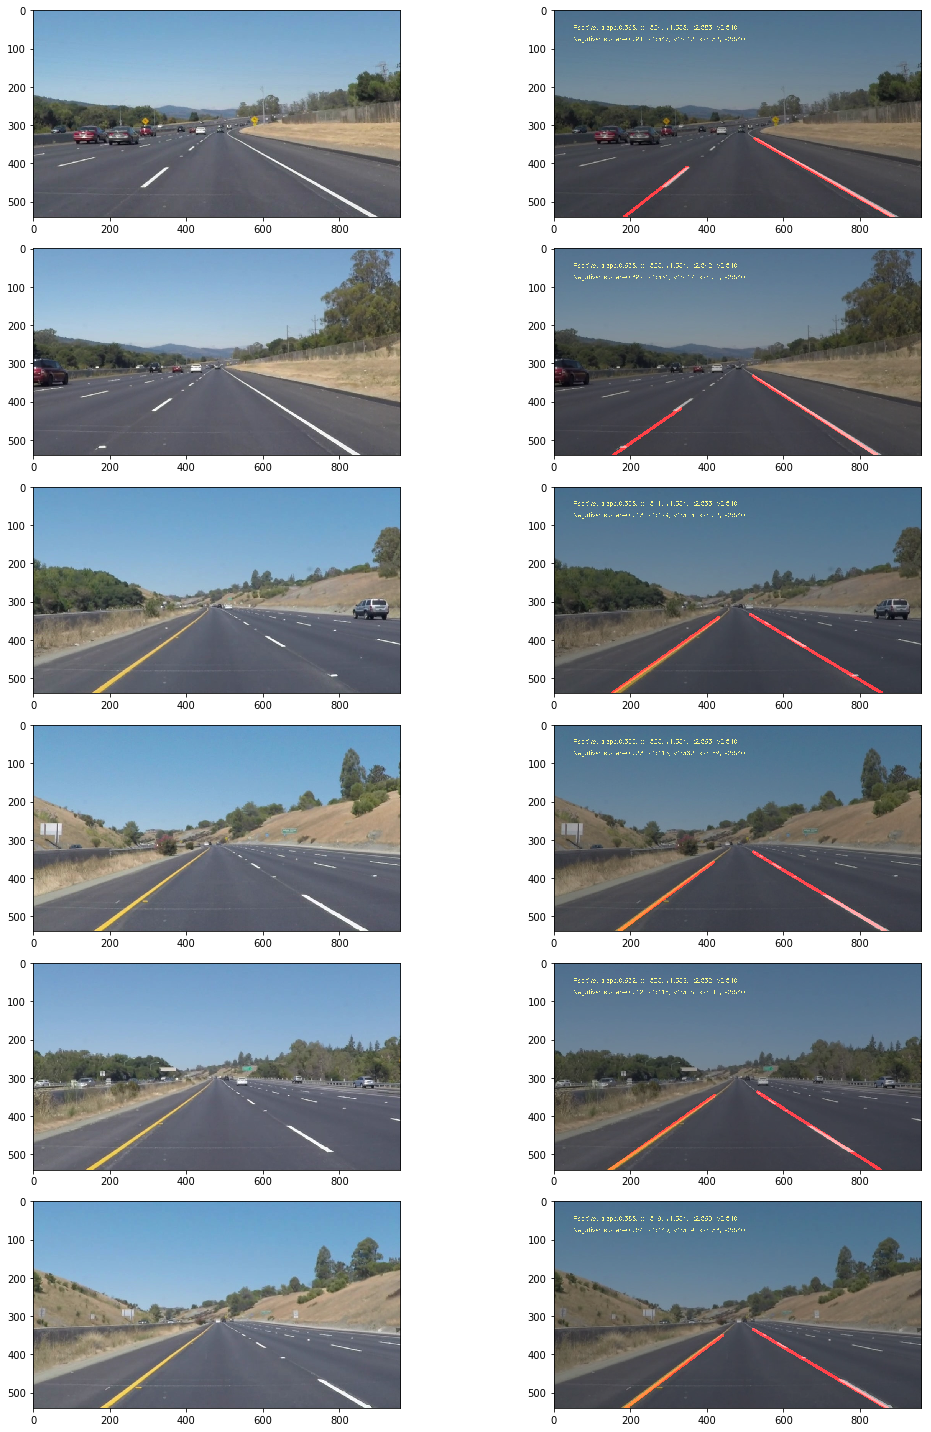

In [6]:
import glob
import matplotlib
import os

imagesDir = "test_images/"
resultImagesDir = "test_images/Results/"
imageFiles = glob.glob(imagesDir + "*.jpg")

plotCount = min(len(imageFiles), 10)

fig, axes = plt.subplots(nrows=plotCount, ncols=2)

for imageIndex, imageFile in enumerate(imageFiles):
    image = mpimg.imread(imageFile)
    
    directory, fileNameOnly = os.path.split(imageFile)
    fileNameOnly = fileNameOnly[:-4]
    
    resultImage = extractLanes(image)
    
    # resultImage.save(os.path.join(imagesDir, fileNameOnly + "-lanes.jpg"))
    matplotlib.image.imsave(os.path.join(resultImagesDir, fileNameOnly + "-lanes.jpg"), resultImage)
    
    axis = axes[imageIndex][0]
    axis.imshow(image)

    axis = axes[imageIndex][1]
    axis.imshow(resultImage)
    
fig.set_figheight(20)
fig.set_figwidth(16)
fig.tight_layout()

plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# import imageio

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)
    
    result = extractLanes(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = "test_videos_output/solidWhiteRight.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:04<00:00, 50.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.98 s


In [ ]:
# white_clip.write_gif("test_videos_output/solidWhiteRight.gif")

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this stage, we go back (already done) and modify our draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)

%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:15<00:00, 43.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 16.2 s


In [22]:
# yellow_clip.write_gif("test_videos_output/solidYellowLeft.gif")


[MoviePy] Building file test_videos_output/solidYellowLeft.gif with imageio


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [01:06<00:00,  9.34it/s]


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)

%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:10<00:00, 24.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 11.5 s


In [23]:
challenge_clip.write_gif("test_videos_output/challenge.gif")


[MoviePy] Building file test_videos_output/challenge.gif with imageio


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [01:00<00:00,  4.31it/s]


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))